In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **1. Make dataset**

In [2]:
# Loading the datasets
#HPI = pd.read_csv("USSTHPI.csv") # Quarterly HPI data
HPI_PO = pd.read_csv("HPI_Purchase_only_yoy_change.csv") # HPI Purchase Only data
EHS = pd.read_excel("Existing Home Sales.xlsx") # Existing Home Sales data, Chris supplied
StockQt = pd.read_excel("HousingStockWorksheet.xlsx", sheet_name = "Stock_Quarterly") # Housing Stock data, Chris supplied

In [3]:
# Just chaging the column name and cleaning the data
HPI_PO.DATE = pd.to_datetime(HPI_PO.DATE)
new_name = {'HPIPONM226S_PC1' : "YoY_HPI"}
HPI_PO.rename(columns=new_name, inplace= True)
HPI_PO.drop(HPI_PO.tail(1).index, inplace= True)
HPI_PO.YoY_HPI = HPI_PO.YoY_HPI.astype(float)

In [4]:
StockQt.rename(columns={"Unnamed: 15" : "col 15", "Unnamed: 16" : "Eff_HS_US"}, inplace=True)
StockQt.drop(columns=["col 15"], inplace= True)
StockQt.dropna(subset=["Eff_HS_US"],inplace = True)
Quarters = StockQt.Quarter.values
Quarter_to_Date = {"Q1" : "-01-01",
                  "Q2" : "-04-01",
                  "Q3" : "-07-01",
                  "Q4" : "-10-01"}
Dates = []
for i in Quarters:
    y = i.split()[0]
    y+= Quarter_to_Date[i.split()[1]]
    Dates.append(y)
StockQt.Quarter = Dates

In [5]:
EHS.EOM = pd.to_datetime(EHS.EOM)
EHS.rename(columns= {"EOM" : "DATE"}, inplace = True)
EHS.dropna(subset=["Existing Home Sales"], inplace=True)

In [6]:
EHS["DATE"] = EHS.DATE.dt.to_period('Q')
EHS_Q = pd.DataFrame(EHS.groupby("DATE").mean())
EHS_Q.reset_index(inplace= True)
EHS_Q.drop(EHS_Q.tail(1).index,inplace=True)

In [7]:
EHS_Q["House_Stock"] = StockQt.Eff_HS_US.values

In [8]:
EHS_Q["Implied_Turnover"] = (EHS_Q["Existing Home Sales"]/(EHS_Q.House_Stock/1000))*100

In [9]:
Turnover = list(EHS_Q.Implied_Turnover.values)
Turnover = [np.nan]*(HPI_PO.shape[0]-len(Turnover))+Turnover
HPI_PO["Implied_Turnover"] = Turnover

In [10]:
HPI_PO

,DATE,YoY_HPI,Implied_Turnover
0,1992-01-01,2.35603,NaN
1,1992-04-01,2.14440,NaN
2,1992-07-01,2.77548,NaN
3,1992-10-01,2.74108,NaN
4,1993-01-01,1.53561,NaN
...,...,...,...
116,2021-01-01,13.08681,6.684530
117,2021-04-01,17.81826,6.321918
118,2021-07-01,18.60512,6.440745
119,2021-10-01,17.70045,6.539117


In [11]:
HPI_PO["YoY_HPI_MA_4"] = HPI_PO.YoY_HPI.rolling(4).mean()

In [12]:
for i in range(4):
    HPI_PO[f'YOY_HPI_Lag_{i+1}']= HPI_PO['YoY_HPI'].shift(i+1)

In [13]:
HPI_PO

,DATE,YoY_HPI,Implied_Turnover,YoY_HPI_MA_4,YOY_HPI_Lag_1,YOY_HPI_Lag_2,YOY_HPI_Lag_3,YOY_HPI_Lag_4
0,1992-01-01,2.35603,NaN,NaN,NaN,NaN,NaN,NaN
1,1992-04-01,2.14440,NaN,NaN,2.35603,NaN,NaN,NaN
2,1992-07-01,2.77548,NaN,NaN,2.14440,2.35603,NaN,NaN
3,1992-10-01,2.74108,NaN,2.504247,2.77548,2.14440,2.35603,NaN
4,1993-01-01,1.53561,NaN,2.299142,2.74108,2.77548,2.14440,2.35603
...,...,...,...,...,...,...,...,...
116,2021-01-01,13.08681,6.684530,9.569690,11.17118,8.25959,5.76118,6.23889
117,2021-04-01,17.81826,6.321918,12.583960,13.08681,11.17118,8.25959,5.76118
118,2021-07-01,18.60512,6.440745,15.170343,17.81826,13.08681,11.17118,8.25959
119,2021-10-01,17.70045,6.539117,16.802660,18.60512,17.81826,13.08681,11.17118


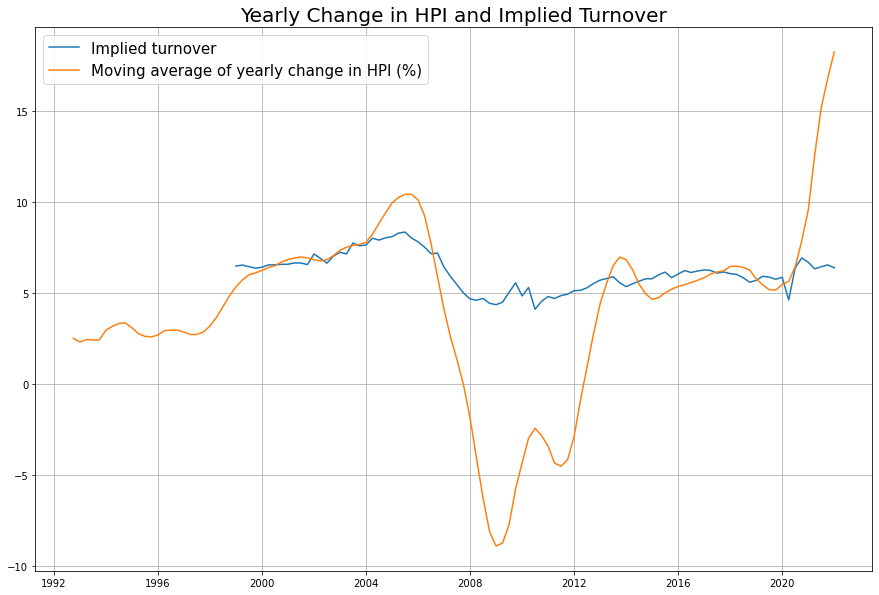

In [14]:
plt.figure(figsize=(15,10))
#plt.plot(HPI_PO.DATE, HPI_PO.YoY.values, label = "Yearly change in HPI (%)")
plt.plot(HPI_PO.DATE, HPI_PO.Implied_Turnover.values, label = "Implied turnover")
plt.plot(HPI_PO.DATE, HPI_PO.YoY_HPI_MA_4, label = "Moving average of yearly change in HPI (%)")
plt.legend(fontsize = 15)
plt.grid()
plt.title("Yearly Change in HPI and Implied Turnover", size = 20);

In [15]:
HPI_df = HPI_PO.dropna().reset_index(drop=True)

In [16]:
HPI_df

,DATE,YoY_HPI,Implied_Turnover,YoY_HPI_MA_4,YOY_HPI_Lag_1,YOY_HPI_Lag_2,YOY_HPI_Lag_3,YOY_HPI_Lag_4
0,1999-01-01,5.93694,6.477936,5.333285,5.70589,5.16140,4.52891,3.91376
1,1999-04-01,6.02527,6.529750,5.707375,5.93694,5.70589,5.16140,4.52891
2,1999-07-01,6.29097,6.447134,5.989768,6.02527,5.93694,5.70589,5.16140
3,1999-10-01,6.14804,6.359195,6.100305,6.29097,6.02527,5.93694,5.70589
4,2000-01-01,6.46462,6.412796,6.232225,6.14804,6.29097,6.02527,5.93694
...,...,...,...,...,...,...,...,...
88,2021-01-01,13.08681,6.684530,9.569690,11.17118,8.25959,5.76118,6.23889
89,2021-04-01,17.81826,6.321918,12.583960,13.08681,11.17118,8.25959,5.76118
90,2021-07-01,18.60512,6.440745,15.170343,17.81826,13.08681,11.17118,8.25959
91,2021-10-01,17.70045,6.539117,16.802660,18.60512,17.81826,13.08681,11.17118


In [17]:
HCAI = pd.read_csv("HCAI_WM.csv")

In [18]:
HCAI.rename(columns = {'Total\nRisk':'Total_Risk', 'Borrower\nRisk':'Borrower_Risk', 'Product\nRisk':'Product_Risk'}, inplace = True)

In [19]:
HCAI = HCAI[4:].reset_index(drop=True)

In [20]:
num_col = ['Total_Risk', 'Borrower_Risk', 'Product_Risk']
for col in num_col:
    HCAI[col] = HCAI[col].astype('float64')

In [21]:
HCAI

,Year,Quarter,Total_Risk,Borrower_Risk,Product_Risk
0,1999,1,11.236,8.836,2.400
1,1999,2,11.790,9.040,2.750
2,1999,3,13.209,9.471,3.737
3,1999,4,14.332,10.160,4.172
4,2000,1,14.764,10.372,4.393
...,...,...,...,...,...
86,2020,3,4.989,4.986,0.003
87,2020,4,5.082,5.078,0.003
88,2021,1,5.125,5.121,0.004
89,2021,2,5.145,5.138,0.007


In [22]:
HCAI_index = HCAI.index.to_list()
HCAI_Y = HCAI.Year.values
HCAI_Q = HCAI.Quarter.values
Quarter_to_Date = {1 : "-01-01", 2 : "-04-01",  3 : "-07-01", 4 : "-10-01"}
Dates = []
for i in HCAI_index:
    date = str(HCAI_Y[i])+Quarter_to_Date[HCAI_Q[i]]
    Dates.append(date)
HCAI['DATE'] = pd.to_datetime(Dates)

In [23]:
HCAI.drop(['Year', 'Quarter'], axis=1, inplace=True)

In [24]:
HCAI

,Total_Risk,Borrower_Risk,Product_Risk,DATE
0,11.236,8.836,2.400,1999-01-01
1,11.790,9.040,2.750,1999-04-01
2,13.209,9.471,3.737,1999-07-01
3,14.332,10.160,4.172,1999-10-01
4,14.764,10.372,4.393,2000-01-01
...,...,...,...,...
86,4.989,4.986,0.003,2020-07-01
87,5.082,5.078,0.003,2020-10-01
88,5.125,5.121,0.004,2021-01-01
89,5.145,5.138,0.007,2021-04-01


In [25]:
df_hpi_hcai=HPI_df.merge(HCAI, how='left')

In [26]:
df_hpi_hcai.drop(['Borrower_Risk', 'Product_Risk'], axis=1, inplace=True)

In [27]:
df_hpi_hcai.rename(columns={'Total_Risk':'HCAI'}, inplace = True)

In [28]:
df_hpi_hcai.dropna(inplace=True)

# **2. Train models**

Let us test each lag features.

In [29]:
df_hpi_hcai.columns

Index(['DATE', 'YoY_HPI', 'Implied_Turnover', 'YoY_HPI_MA_4', 'YOY_HPI_Lag_1',
       'YOY_HPI_Lag_2', 'YOY_HPI_Lag_3', 'YOY_HPI_Lag_4', 'HCAI'],
      dtype='object')

In [30]:
features = ['YoY_HPI', 'YoY_HPI_MA_4', 'YOY_HPI_Lag_1',
            'YOY_HPI_Lag_2', 'YOY_HPI_Lag_3', 'YOY_HPI_Lag_4', 'HCAI']

In [31]:
df_hpi_hcai.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 0 to 90
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATE              91 non-null     datetime64[ns]
 1   YoY_HPI           91 non-null     float64       
 2   Implied_Turnover  91 non-null     float64       
 3   YoY_HPI_MA_4      91 non-null     float64       
 4   YOY_HPI_Lag_1     91 non-null     float64       
 5   YOY_HPI_Lag_2     91 non-null     float64       
 6   YOY_HPI_Lag_3     91 non-null     float64       
 7   YOY_HPI_Lag_4     91 non-null     float64       
 8   HCAI              91 non-null     float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 7.1 KB


In [44]:
import statsmodels.api as sm
from scipy import stats

def test_features():
    for col in features:
        X = df_hpi_hcai[col]
        y = df_hpi_hcai['Implied_Turnover']
        X1 = sm.add_constant(X)
        print(f'========================== p-value table of {col} ==============================')
        print(sm.OLS(y,X).fit().summary())
        print('=======================================================================================')

In [45]:
test_features()

========================== p-value table of YoY_HPI ==============================
                                 OLS Regression Results                                
Dep. Variable:       Implied_Turnover   R-squared (uncentered):                   0.523
Model:                            OLS   Adj. R-squared (uncentered):              0.518
Method:                 Least Squares   F-statistic:                              98.73
Date:                Thu, 21 Jul 2022   Prob (F-statistic):                    3.88e-16
Time:                        21:03:55   Log-Likelihood:                         -261.62
No. Observations:                  91   AIC:                                      525.2
Df Residuals:                      90   BIC:                                      527.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err     

Now, I decided to model 'Implied Turnover' by features 'YoY_HPI_MA_4' and 'HCAI'.

In [46]:
new_fea = ['YoY_HPI_MA_4', 'HCAI']

In [49]:
X = df_hpi_hcai[new_fea]
Y = df_hpi_hcai['Implied_Turnover']
X1 = sm.add_constant(X)
model = sm.OLS(Y, X1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Implied_Turnover   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     246.5
Date:                Thu, 21 Jul 2022   Prob (F-statistic):           8.64e-37
Time:                        21:18:38   Log-Likelihood:                -44.025
No. Observations:                  91   AIC:                             94.05
Df Residuals:                      88   BIC:                             101.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.4435      0.105     42.449   

#  **3. Forecast Covid period**

## **3.1 Time Series Cross-Validation**

In [55]:
covid_period = df_hpi_hcai[df_hpi_hcai['DATE']>='2020-01-01']
pre_covid = df_hpi_hcai[df_hpi_hcai['DATE']<'2020-01-01']

In [56]:
covid_period

,DATE,YoY_HPI,Implied_Turnover,YoY_HPI_MA_4,YOY_HPI_Lag_1,YOY_HPI_Lag_2,YOY_HPI_Lag_3,YOY_HPI_Lag_4,HCAI
84,2020-01-01,6.23889,5.860617,5.462100,5.52464,4.99680,5.08807,4.99882,5.300
85,2020-04-01,5.76118,4.613646,5.630378,6.23889,5.52464,4.99680,5.08807,5.137
86,2020-07-01,8.25959,6.377489,6.446075,5.76118,6.23889,5.52464,4.99680,4.989
87,2020-10-01,11.17118,6.925938,7.857710,8.25959,5.76118,6.23889,5.52464,5.082
88,2021-01-01,13.08681,6.684530,9.569690,11.17118,8.25959,5.76118,6.23889,5.125
89,2021-04-01,17.81826,6.321918,12.583960,13.08681,11.17118,8.25959,5.76118,5.145
90,2021-07-01,18.60512,6.440745,15.170343,17.81826,13.08681,11.17118,8.25959,5.169


In [57]:
pre_covid

,DATE,YoY_HPI,Implied_Turnover,YoY_HPI_MA_4,YOY_HPI_Lag_1,YOY_HPI_Lag_2,YOY_HPI_Lag_3,YOY_HPI_Lag_4,HCAI
0,1999-01-01,5.93694,6.477936,5.333285,5.70589,5.16140,4.52891,3.91376,11.236
1,1999-04-01,6.02527,6.529750,5.707375,5.93694,5.70589,5.16140,4.52891,11.790
2,1999-07-01,6.29097,6.447134,5.989768,6.02527,5.93694,5.70589,5.16140,13.209
3,1999-10-01,6.14804,6.359195,6.100305,6.29097,6.02527,5.93694,5.70589,14.332
4,2000-01-01,6.46462,6.412796,6.232225,6.14804,6.29097,6.02527,5.93694,14.764
...,...,...,...,...,...,...,...,...,...
79,2018-10-01,5.63650,5.589359,6.259412,6.04784,6.39748,6.95583,6.22040,5.861
80,2019-01-01,4.99882,5.688520,5.770160,5.63650,6.04784,6.39748,6.95583,5.981
81,2019-04-01,5.08807,5.915254,5.442808,4.99882,5.63650,6.04784,6.39748,5.805
82,2019-07-01,4.99680,5.866748,5.180048,5.08807,4.99882,5.63650,6.04784,5.515


In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

models = []
rmse = []
X, y = pre_covid[new_fea], pre_covid['Implied_Turnover']
tscv = TimeSeriesSplit(n_splits=5)
for fold, (train_index, test_index) in enumerate(tscv.split(pre_covid)):
    print(f'========================== Fold {fold} ===========================')
    print(f'========== Training index is : {train_index}===========')
    print(f'========== Test index is : {test_index}===========')
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    models.append(model)
    predictions = model.predict(X_test)
    rmse.append(np.sqrt(mean_squared_error(y_test, predictions)))
print("RMSE: {}".format(np.mean(rmse)))

========================== Fold 0 ===========================
========== Training index is : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]===========
========== Test index is : [14 15 16 17 18 19 20 21 22 23 24 25 26 27]===========
========================== Fold 1 ===========================
========== Training index is : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]===========
========== Test index is : [28 29 30 31 32 33 34 35 36 37 38 39 40 41]===========
========================== Fold 2 ===========================
========== Training index is : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]===========
========== Test index is : [42 43 44 45 46 47 48 49 50 51 52 53 54 55]===========
========================== Fold 3 ===========================
========== Training index is : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 

In [77]:
X_covid = covid_period[new_fea]
y_pred_col = []
y_hist_col = []
for model in models:
    y_hist_col.append(model.predict(pre_covid[new_fea]))
    y_pred_col.append(model.predict(X_covid))
    y_pred = np.mean(y_pred_col,axis=0)
    y_hist = np.mean(y_hist_col, axis=0)
y_pred, y_hist

(array([6.30141245, 6.33298382, 6.50874807, 6.82528038, 7.20668927,
        7.87626118, 8.45102678]),
 array([6.4829289 , 6.58554759, 6.69843473, 6.76271067, 6.80727394,
        6.82134928, 6.8212275 , 6.86234604, 6.87769431, 6.87951382,
        6.88414443, 6.86747648, 6.84649482, 6.83911873, 6.84803618,
        6.89118194, 6.9643148 , 7.00192209, 7.02041152, 7.07781051,
        7.13426433, 7.23850052, 7.41003828, 7.5380048 , 7.66372021,
        7.73771472, 7.76501803, 7.79445993, 7.74645914, 7.54741161,
        7.21111801, 6.80689578, 6.33320256, 5.86323608, 5.55256863,
        5.23764769, 4.77337752, 4.21071136, 3.72819849, 3.32787074,
        3.15670341, 3.18817271, 3.41680405, 3.87354419, 4.19693118,
        4.50304938, 4.61805268, 4.51545397, 4.38073998, 4.16939864,
        4.13707153, 4.22001834, 4.50550162, 4.94920524, 5.34031025,
        5.74740048, 6.08853741, 6.32092192, 6.52603511, 6.63071708,
        6.59784287, 6.47510182, 6.30099217, 6.18918257, 6.12437285,
        6.1381

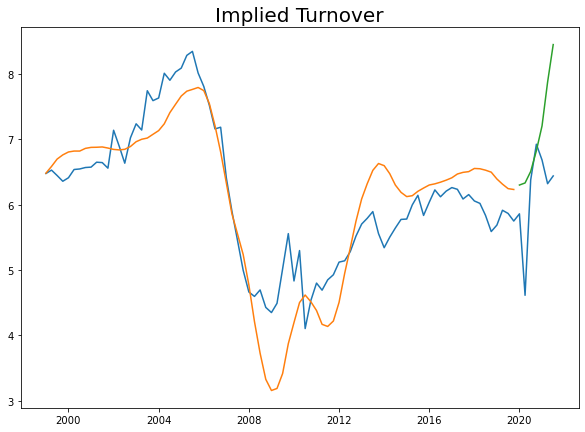

In [81]:
plt.figure(figsize=(10,7))
plt.plot(df_hpi_hcai.DATE, df_hpi_hcai.Implied_Turnover.values, label = "Implied turnover")
plt.plot(pre_covid.DATE, y_hist, label = "Fitted implied turnover")
plt.plot(covid_period.DATE, y_pred, label = "Predicted implied turnover")
#plt.legend(fontsize = 15)
plt.title("Implied Turnover", size = 20);

## **3.2 Using pre-covid period**

In [ ]:
#X_train, y_train = train['YoY_MA_5'], train['Implied_Turnover']
#X_test, y_test = test['YoY_MA_5'], test['Implied_Turnover']

In [ ]:
#X_train=np.array(X_train).reshape(-1, 1)
#X_test= np.array(X_test).reshape(-1, 1)

In [ ]:
#from sklearn.linear_model import LinearRegression

# Fit and predict
#model = LinearRegression()  
#model.fit(X_train, y_train)
#y_pred = model.predict(X_train)
#y_fore = model.predict(X_test)

In [ ]:
#plt.figure(figsize=(10,7))
#plt.plot(HPI_df.DATE, HPI_df.Implied_Turnover.values, label = "Implied turnover")
#plt.plot(train.DATE, y_pred, label = "Fitted implied turnover")
#plt.plot(test.DATE, y_fore, label = "Predicted implied turnover")
#plt.legend(fontsize = 15)
#plt.title("Moving average of yearly change in HPI (%) v.s. Implied Turnover", size = 20);

In [ ]:
#from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
#mae = mean_absolute_error(y_test, y_fore)
#mse = mean_squared_error(y_test, y_fore)
#rmse = np.sqrt(mse)

In [ ]:
#print(f'Mean absolute error: {mae:.5f}')
#print(f'Mean squared error: {mse:.5f}')
#print(f'Root mean squared error: {rmse:.5f}')

In [ ]:
#train1, test1 = df_hpi_hcai.iloc[:size,:], df_hpi_hcai.iloc[size:,:]

In [ ]:
#X1_train, y1_train = train1[features], train1['Implied_Turnover']
#X1_test, y1_test = test1[features], test1['Implied_Turnover']

In [ ]:
# Fit and predict
#model1 = LinearRegression()  
#model1.fit(X1_train, y1_train)
#y1_pred = model1.predict(X1_train)
#y1_fore = model1.predict(X1_test)

In [ ]:
#plt.figure(figsize=(10,7))
#plt.plot(df_hpi_hcai.DATE, df_hpi_hcai.Implied_Turnover.values, label = "Implied turnover")
#plt.plot(train1.DATE, y1_pred, label = "Fitted implied turnover")
#plt.plot(test1.DATE, y1_fore, label = "Predicted implied turnover")
#plt.legend(fontsize = 15)
#plt.title("Moving average of yearly change in HPI (%) v.s. Implied Turnover", size = 20);

In [ ]:
#mae1 = mean_absolute_error(y1_test, y1_fore)
#mse1 = mean_squared_error(y1_test, y1_fore)
#rmse1 = np.sqrt(mse1)

In [ ]:
#print(f'Mean absolute error: {mae1:.5f}')
#print(f'Mean squared error: {mse1:.5f}')
#print(f'Root mean squared error: {rmse1:.5f}')